# Logistic Regression


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from collections import Counter

In [3]:
%config Completer.use_jedi = False

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [4]:
df = pd.read_csv('bank-full.csv',sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.shape

(45211, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
df.describe().astype(np.int64)

,age,balance,day,duration,campaign,pdays,previous
count,45211,45211,45211,45211,45211,45211,45211
mean,40,1362,15,258,2,40,0
std,10,3044,8,257,3,100,2
min,18,-8019,1,0,1,-1,0
25%,33,72,8,103,1,-1,0
50%,39,448,16,180,2,-1,0
75%,48,1428,21,319,3,-1,0
max,95,102127,31,4918,63,871,275


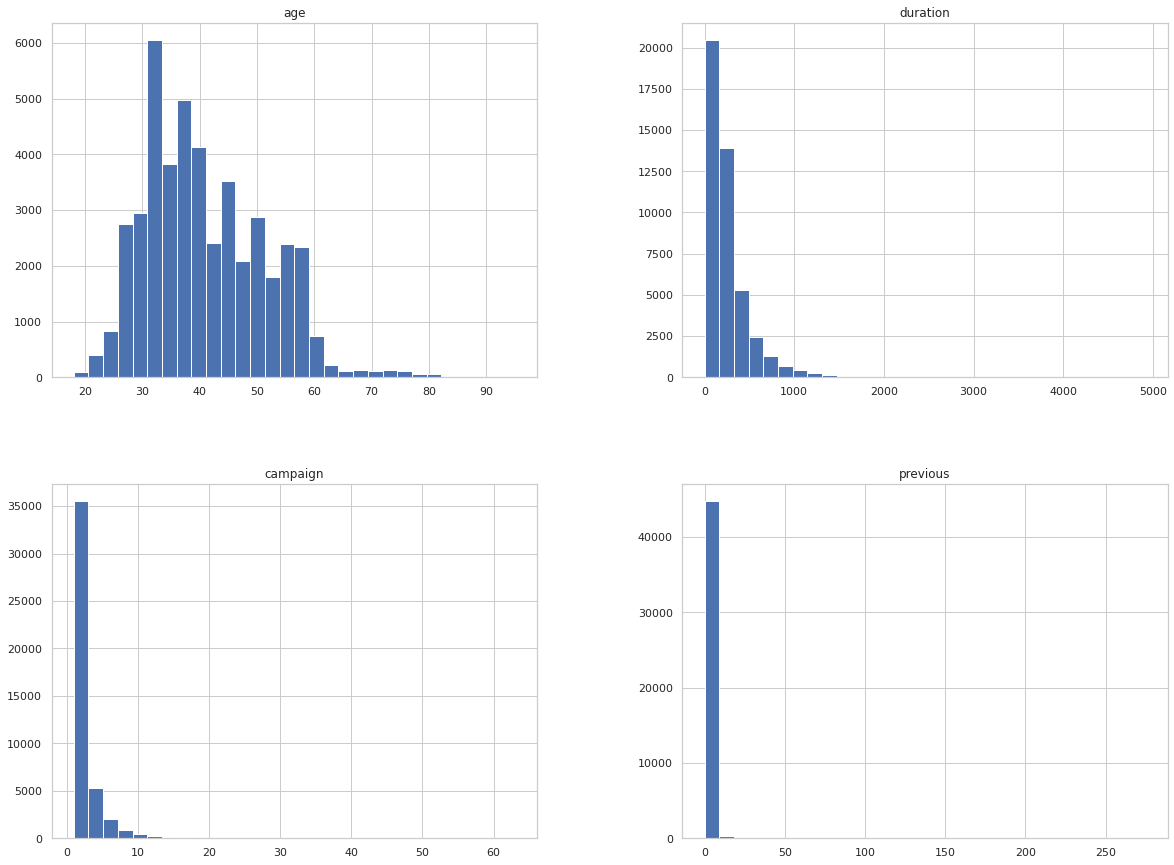

In [8]:
%matplotlib inline
df[['age','duration','campaign','previous']].hist(bins=30, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

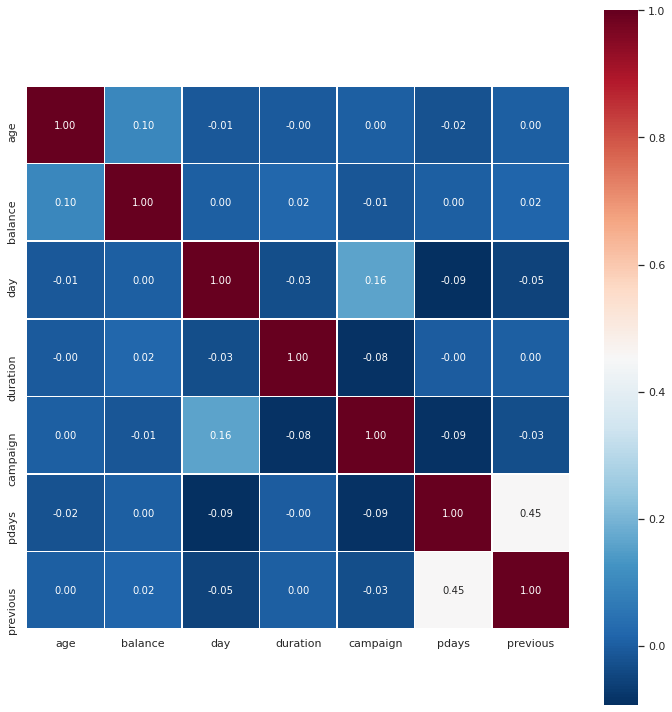

In [9]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(df._get_numeric_data().astype(float).corr(),
            square=True, cmap='RdBu_r', linewidths=.5,
            annot=True, fmt='.2f').figure.tight_layout()
plt.show()

In [10]:
category_features = df.select_dtypes(include=['object', 'bool']).columns.values

for col in category_features:
    print(col, "(", len(df[col].unique()) , "values):\n", np.sort(df[col].unique()))

job ( 12 values):
 ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
marital ( 3 values):
 ['divorced' 'married' 'single']
education ( 4 values):
 ['primary' 'secondary' 'tertiary' 'unknown']
default ( 2 values):
 ['no' 'yes']
housing ( 2 values):
 ['no' 'yes']
loan ( 2 values):
 ['no' 'yes']
contact ( 3 values):
 ['cellular' 'telephone' 'unknown']
month ( 12 values):
 ['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
poutcome ( 4 values):
 ['failure' 'other' 'success' 'unknown']
y ( 2 values):
 ['no' 'yes']


In [11]:
for col in category_features:
    print(f"\033[1m\033[94m{col} \n{20 * '-'}\033[0m")    
    print(df[col].value_counts(), "\n")
    
print(df.nunique(axis=1))

job 
--------------------
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64 

marital 
--------------------
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64 

education 
--------------------
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64 

default 
--------------------
no     44396
yes      815
Name: default, dtype: int64 

housing 
--------------------
yes    25130
no     20081
Name: housing, dtype: int64 

loan 
--------------------
no     37967
yes     7244
Name: loan, dtype: int64 

contact 
--------------------
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64 

month 
--------------------
may    13766
jul     6895
aug    

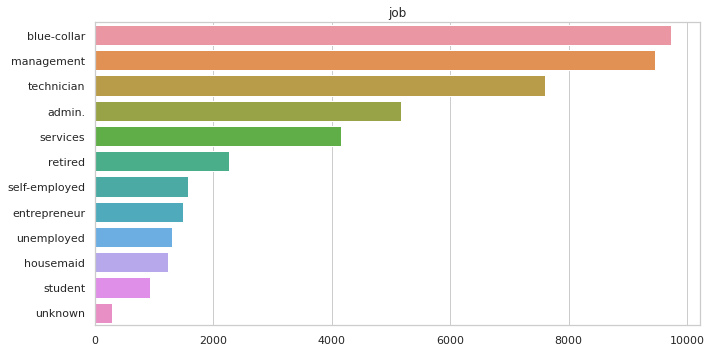

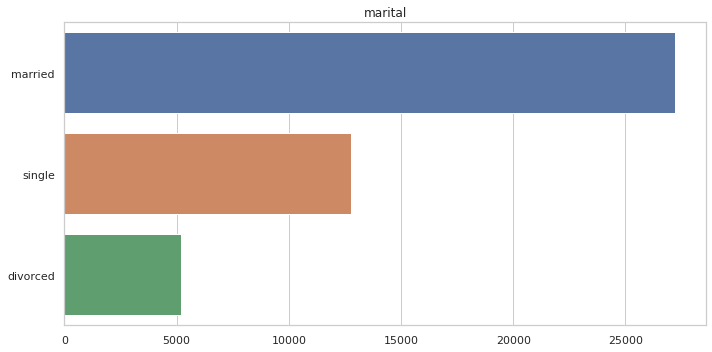

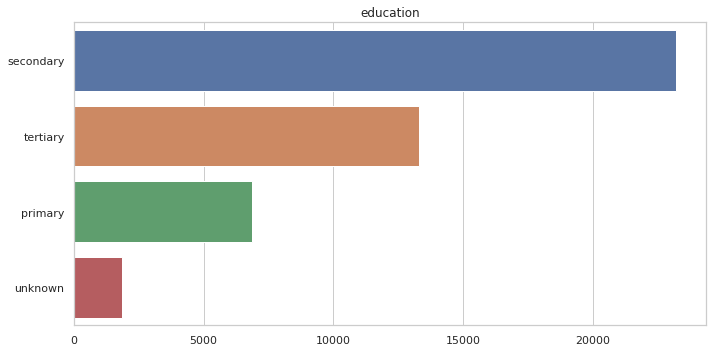

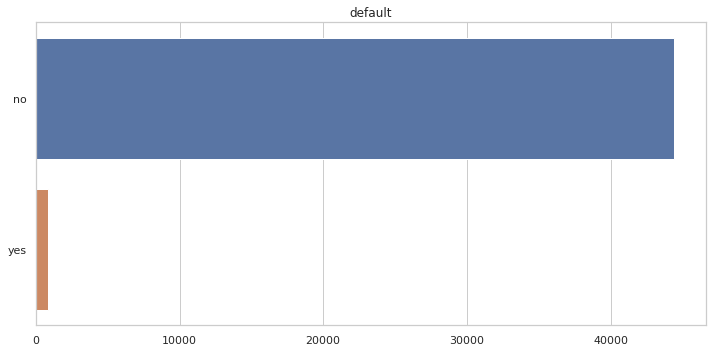

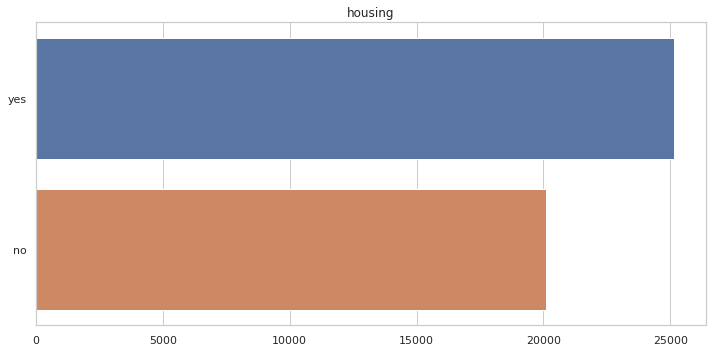

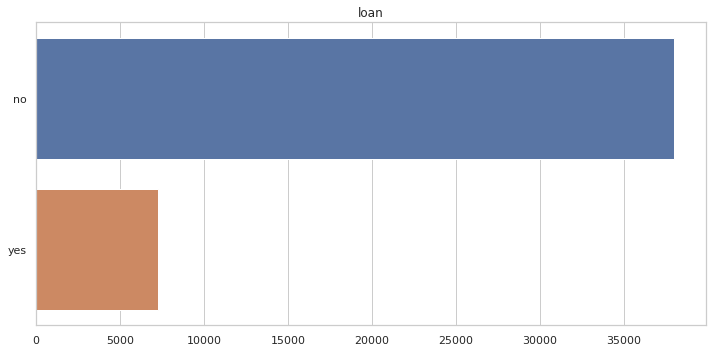

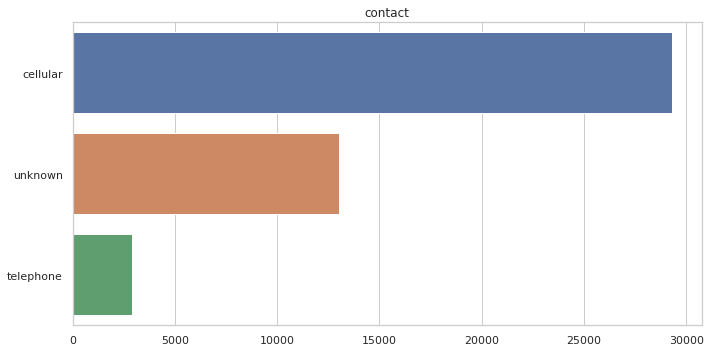

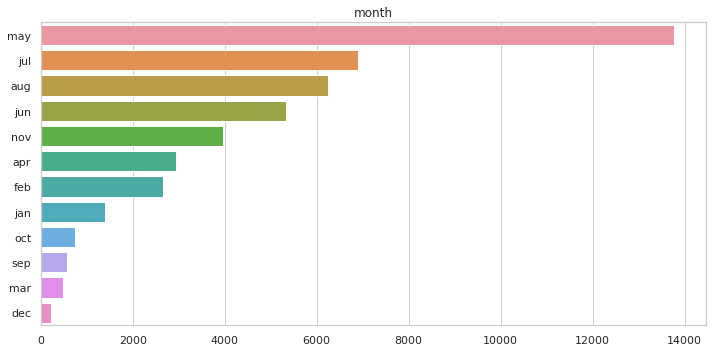

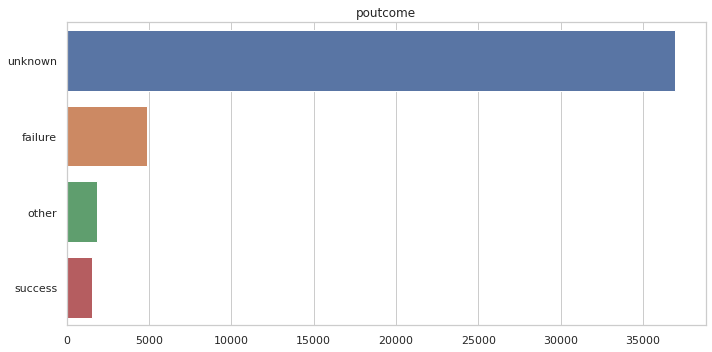

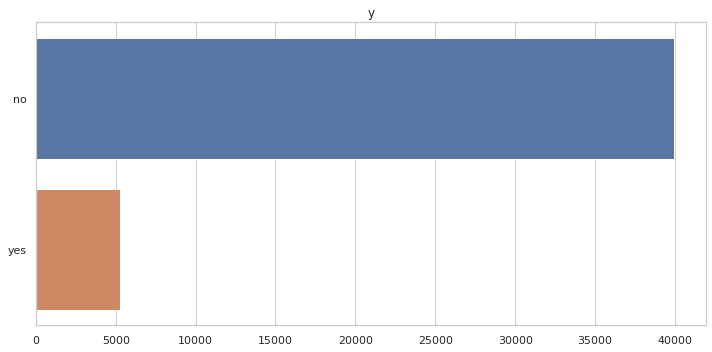

In [12]:
for col in category_features:
    plt.figure(figsize=(10,5))    
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index, data=df)    
    plt.title(col)    
    plt.tight_layout()

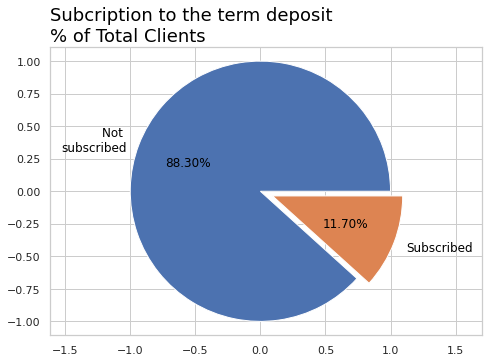

In [13]:
labels = ["Not \nsubscribed", "Subscribed"]
explode = (0, 0.1)

 fig = plt.figure() 
ax = fig.add_axes([0,0,1,1]) 

ax.pie(df['y'].value_counts(), 
       labels = labels,
       explode = explode,
       autopct ='%1.2f%%',
       frame = True,
       textprops = dict(color ="black", size=12)) 

ax.axis('equal') 
plt.title('Subcription to the term deposit\n% of Total Clients',
     loc='left',
     color = 'black', 
     fontsize = '18')

plt.show()

In [14]:
df.groupby(['campaign'])['y'].count().reset_index().sort_values(by='y', ascending=False).iloc[:5]

,campaign,y
0,1,17544
1,2,12505
2,3,5521
3,4,3522
4,5,1764


Text(0, 0.5, 'Frequency of Purchase')

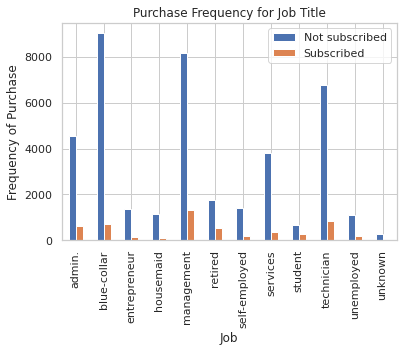

In [15]:
table = pd.crosstab(df.job, df.y)
table.columns = ['Not subscribed', 'Subscribed']
table.plot(kind='bar')

plt.grid(True)

plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

In [16]:
table = pd.crosstab(df.job, df.y)
table = round(table.div(table.sum(axis=1), axis=0).mul(100), 2)
table.columns=['notsubcribed', 'subcribed']
table.sort_values(by=['subcribed'], ascending=False).loc[:, 'subcribed']

job
student          28.68
retired          22.79
unemployed       15.50
management       13.76
admin.           12.20
self-employed    11.84
unknown          11.81
technician       11.06
services          8.88
housemaid         8.79
entrepreneur      8.27
blue-collar       7.27
Name: subcribed, dtype: float64

Text(0, 0.5, 'Proportion of Customers')

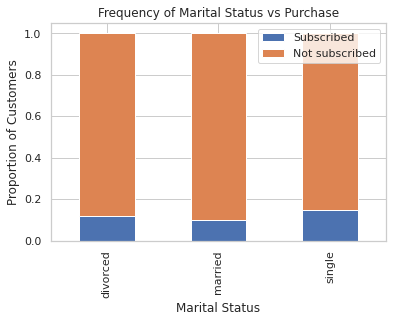

In [17]:
table = pd.crosstab(df.marital,df.y)
table = table.div(table.sum(1).astype(float), axis=0)
table.columns = ['Not subscribed', 'Subscribed']
table[['Subscribed', 'Not subscribed']].plot(kind='bar', stacked=True)
plt.title('Frequency of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

In [18]:
df = df.drop(['duration'], axis=1)

In [19]:
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (36168, 15)
Number transactions y_train dataset:  (36168,)
Number transactions X_test dataset:  (9043, 15)
Number transactions y_test dataset:  (9043,)


In [20]:
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.values
numeric_features = numeric_features[numeric_features != 'y']

category_features = X_train.select_dtypes(include=['object', 'bool']).columns.values

print(numeric_features)
print(category_features)

['age' 'balance' 'day' 'campaign' 'pdays' 'previous']
['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'poutcome']


In [21]:
def dummify(ohe, x, columns):
    transformed_array = ohe.transform(x)

    
    enc = ohe.named_transformers_['cat'].named_steps['onehot']
    feature_lst = enc.get_feature_names(category_features.tolist())   
    
    cat_colnames = np.concatenate([feature_lst]).tolist()
    all_colnames = numeric_features.tolist() + cat_colnames 
    df = pd.DataFrame(transformed_array, index = x.index, columns = all_colnames)
    
    return transformed_array, df

In [22]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, category_features)])

ohe = preprocessor.fit(X_train)

X_train_t = ohe.transform(X_train)
X_test_t = ohe.transform(X_test)

In [23]:
X_train_t_array, X_train_t = dummify(ohe, X_train, category_features)
X_test_t_array, X_test_t = dummify(ohe, X_test, category_features)

X_train_t.head()

,age,balance,day,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
13932,1.515061,-0.231637,-0.698514,-0.567836,-0.410222,-0.241405,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9894,-0.369597,0.106038,-0.818717,-0.567836,-0.410222,-0.241405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39946,-0.558063,0.470635,-1.660136,0.402837,0.560728,0.585721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9217,-0.558063,-0.375660,-1.299528,-0.567836,-0.410222,-0.241405,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4124,-0.275365,-0.340303,0.383311,-0.567836,-0.410222,-0.241405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
X_train_columns = X_train_t.columns
print(X_train_columns)

Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [25]:
from imblearn.over_sampling import SMOTE
counter = Counter(y_train)
print(counter)

oversample = SMOTE()
X_train_smote, y_train = oversample.fit_resample(X_train_t, y_train)

counter = Counter(y_train)
print(counter)

Counter({'no': 31942, 'yes': 4226})
Counter({'yes': 31942, 'no': 31942})


In [26]:
from sklearn.svm import SVC

final_X_train = pd.DataFrame(data=X_train_smote,columns=X_train_columns )
final_y_train = pd.DataFrame(data=y_train,columns=['y'])

rfe_model = RFE(LogisticRegression(solver='lbfgs', max_iter=1000), 25)
rfe_model = rfe_model.fit(final_X_train, final_y_train)
print(rfe_model.support_)
print(rfe_model.ranking_)

[False False False False False False False False  True  True False  True
 False False  True False False  True False False  True False False False
 False  True False False  True False  True  True False  True False  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True]
[19 16 26  2 20 18 14 17  1  1 25  1 22  9  1 23 11  1 24 10  1  6 15 12
  7  1  4  5  1  3  1  1 13  1 21  1  1  1  1  1  8  1  1  1  1  1  1  1
  1  1]


In [27]:
selected_columns = X_train_columns[rfe_model.support_]
print(selected_columns.tolist())

['job_entrepreneur', 'job_housemaid', 'job_retired', 'job_student', 'job_unknown', 'marital_single', 'default_no', 'housing_yes', 'loan_yes', 'contact_cellular', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


In [28]:
X_train_final = final_X_train[selected_columns.tolist()]
y_train_final = final_y_train['y']
X_test_final = X_test_t[selected_columns.tolist()]
y_test_final = y_test

X_test_final.head()

,job_entrepreneur,job_housemaid,job_retired,job_student,job_unknown,marital_single,default_no,housing_yes,loan_yes,contact_cellular,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
14001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32046,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13318,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
42991,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X_train_final, y_train_final)

LogisticRegression()

In [31]:
y_pred = logreg.predict(X_test_final)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_final, y_test_final)))

Accuracy of logistic regression classifier on test set: 0.76
